# **AFL Agent Tutorial: Notebook 03** <a href="https://colab.research.google.com/github/martintb/AFL-tutorial/blob/main/notebooks/03-afl-dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The AFL Agent Codebase

# Development Version

*Author: Tyler Martin - tyler.martin@nist.gov*


## Learning Goals

This notebook will introduce the following concepts:

- how to use the AFL.double_agent codebase to build decision pipelines


# Setup

**This may take several minutes to complete, please run ASAP**

Please run this collapsed cell by clicking in the box to the left of *8 cells hidden*. This will `pip install` and `import` all necessary dependencies for this tutorial. There is not need to expand this cell block, but you can if you're interested in looking under the hood.


If you've never used Google Colab before, [this FAQ](https://research.google.com/colaboratory/faq.html) may be useful to skim. It's very similar (and based off of) Jupyter, but divergent in several ways.

**Warning!**

If you disconnect for too long, you'll have to rerun this cell. Any text you type into this notebooks should always be saved, but variables in memory and files can dissappear when you disconnect.

You're free to download this notebook and run it locally if you're inclined, but we will provide no support for this.

In [11]:
!git clone https://github.com/martintb/AFL-tutorial

fatal: destination path 'AFL-tutorial' already exists and is not an empty directory.


In [12]:
!pip install --find-links ./AFL-tutorial/wheels --editable ./AFL-tutorial/
!pip install git+https://github.com/usnistgov/AFL-agent

Looking in links: ./AFL-tutorial/wheels
Obtaining file:///content/AFL-tutorial
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00
  Building editable for AFL-tutorial (pyproject.toml) ... done
  Created wheel for AFL-tutorial: filename=AFL_tutorial-0.1.0-0.editable-py3-none-any.whl size=6820 sha256=bf0008ee43c544b9a31a01da4c22f619636f53d22c3298fb4a3da0c6e5cd0654
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekrhq3_g/wheels/98/4a/14/f51e7f3f1119f06d857ff9857856a309dde8a69cf375432677
Successfully built AFL-tutorial


  Cloning https://github.com/usnistgov/AFL-agent to /tmp/pip-req-build-xyvbz86_
  Running command git clone --filter=blob:none --quiet https://github.com/usnistgov/AFL-agent /tmp/pip-req-build-xyvbz86_
  Resolved https://github.com/usnistgov/AFL-agent to commit 51a636349e008896acc32f1b52cae1532292e2dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import sys
sys.path.insert(0,'./AFL-tutorial')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import os

import sklearn.cluster
from sklearn.metrics import pairwise
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

import plotly.express as px
import plotly.graph_objects as go

import xarray as xr
xr.set_options(display_expand_data=False)

In [22]:
from AFL.double_agent import *
from AFL.double_agent.plotting import *

from AFL.double_agent_tutorial import *
from AFL.double_agent_tutorial.instruments.tutorial import *

In [7]:
np.random.seed(240424)

# Make Starting Dataset

In [8]:
instrument = get_virtual_instrument()
instrument

In [9]:
composition_list = [
    {'a':1/3,'b':1/3,'c':1/3},
    {'a':0.0,'b':0.5,'c':0.5},
    {'a':0.5,'b':0.0,'c':0.5},
    {'a':0.5,'b':0.5,'c':0.0},
]

input_dataset = instrument.measure_multiple(composition_list)
input_dataset

<xarray.Dataset> Size: 10kB
Dimensions:  (sample: 4, q: 250)
Coordinates:
  * q        (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6079 0.6205 0.6334
Dimensions without coordinates: sample
Data variables:
    sas      (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    a        (sample) float64 32B 0.3333 0.0 0.5 0.5
    b        (sample) float64 32B 0.3333 0.5 0.0 0.5
    c        (sample) float64 32B 0.3333 0.5 0.5 0.0

Note that the above code output a dataset with multiple entries in the **sample** dimension. Since the sample dimension does not have a coordinate defined for it, you can index it using integer indices.

Below we show how to plot the **sas** data variable.

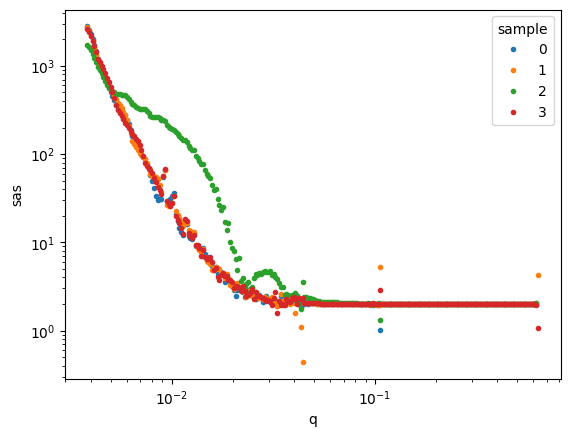

In [10]:
input_dataset.sas.plot.line(
    x='q',
    xscale='log',
    yscale='log',
    marker='.',
    ls='none',
)

We can also plot the compositions using the `plot_ternary` helper function. Remember to double-click the ternary to view the compositions along the edges.

In [11]:
plot_ternary(input_dataset,components=['c','a','b'],include_surface=False)

FigureWidget({
    'data': [{'a': array([0.33333333, 0.5       , 0.5       , 0.        ]),
              'b': array([0.33333333, 0.        , 0.5       , 0.5       ]),
              'c': array([0.33333333, 0.5       , 0.        , 0.5       ]),
              'cliponaxis': False,
              'marker': {'size': 12, 'symbol': 'triangle-up'},
              'mode': 'markers',
              'type': 'scatterternary',
              'uid': '0a3e294d-c229-420b-a897-7786dfa600fd'}],
    'layout': {'showlegend': False,
               'template': '...',
               'ternary': {'aaxis': {'linewidth': 2, 'min': 0.01, 'ticks': 'outside', 'title': {'text': 'c'}},
                           'baxis': {'linewidth': 2, 'min': 0.01, 'ticks': 'outside', 'title': {'text': 'a'}},
                           'caxis': {'linewidth': 2, 'min': 0.01, 'ticks': 'outside', 'title': {'text': 'b'}},
                           'sum': 1},
               'width': 750}
})

# Building an AFL Pipeline

## First Steps

Calculating the first derivative of your data

In [20]:
input_dataset

<xarray.Dataset> Size: 10kB
Dimensions:  (sample: 4, q: 250)
Coordinates:
  * q        (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6079 0.6205 0.6334
Dimensions without coordinates: sample
Data variables:
    sas      (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    a        (sample) float64 32B 0.3333 0.0 0.5 0.5
    b        (sample) float64 32B 0.3333 0.5 0.0 0.5
    c        (sample) float64 32B 0.3333 0.5 0.5 0.0

In [18]:
with Pipeline() as my_first_pipeline:
    SavgolFilter(input_variable='sas', output_variable='sas_deriv1', dim='q', derivative=1)

my_first_pipeline

<Pipeline Pipeline N=1>

In [26]:
result = my_first_pipeline.calculate(input_dataset)
result

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 20kB
Dimensions:     (sample: 4, q: 250, log_q: 245)
Coordinates:
  * q           (q) float64 2kB 0.003836 0.003915 0.003997 ... 0.6205 0.6334
  * log_q       (log_q) float64 2kB -2.416 -2.392 -2.368 ... -0.2106 -0.2085
Dimensions without coordinates: sample
Data variables:
    sas         (sample, q) float64 8kB 2.804e+03 2.546e+03 ... 1.956 1.063
    a           (sample) float64 32B 0.3333 0.0 0.5 0.5
    b           (sample) float64 32B 0.3333 0.5 0.0 0.5
    c           (sample) float64 32B 0.3333 0.5 0.5 0.0
    sas_deriv1  (sample, log_q) float64 8kB -5.743 -5.604 ... -0.03078 -0.03274

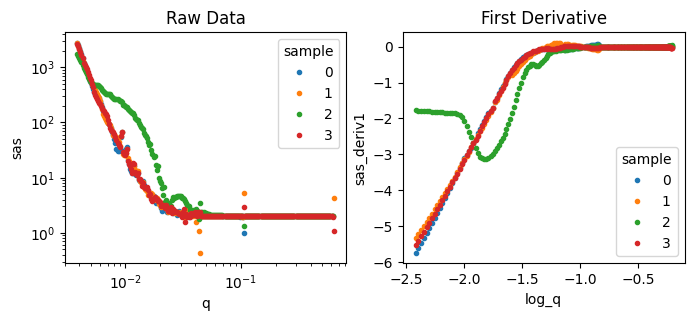

In [34]:
fig,axes = plt.subplots(1,2,figsize=(8,3))
result.sas.plot.line( x='q', xscale='log', yscale='log', marker='.', ls='none', ax=axes[0])
result.sas_deriv1.plot.line( x='log_q', marker='.', ls='none',ax=axes[1]);
axes[0].set_title('Raw Data')
axes[1].set_title('First Derivative');

## A complete Pipeline

## Visualizing Calculations

## Adding a New Pipeline Operation (PipelineOp)

# Autonomous Loop